In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pickle
import estimator as e
import matplotlib.pyplot as plt
import utils as u

# Load data

In [6]:
with open("data/ecb.pkl" , "rb") as f:
    ecb = pickle.load(f)
    ecb.sort_index(inplace=True)
    
with open("data/fed.pkl" , "rb") as f:
    fed = pickle.load(f)
    fed.sort_index(inplace=True)

with open("data/macro_variables.pkl" , "rb") as f:
    data = pickle.load(f)
    data.sort_index(inplace=True)

#Romer-Romer monetary policy shocks
RR = pd.read_stata('data/RR_monetary_shock_monthly.dta')
RR.rename(columns={"date":"Date"}, inplace=True)
RR["Date"] = pd.to_datetime(RR["Date"])
RR.set_index("Date", inplace=True)

fed_surprise = fed[fed["Survey vs Actual"] != "Expected"].dropna()

## Non parametric estimator with "raw treatment"

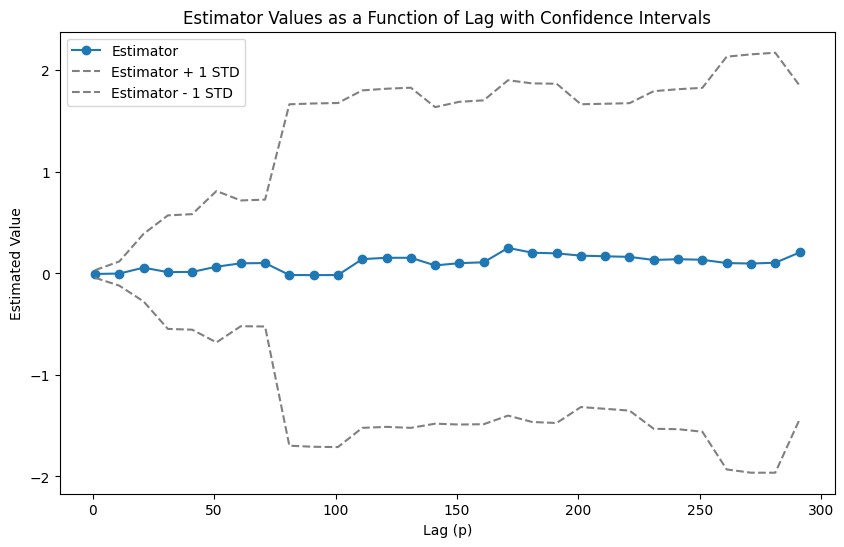

In [8]:
estimator = e.Estimator(W=fed, Y=data,treatment="Numeric Change", outcome="USURTOT Index")
#estimator.compute_estimator(p=10, h=, w=0.1, w_prime=-0.1, min_obs=2)           for usage example
estimator.plot_effect( h=15, w=50, w_prime=0, p_range=[k for k in range(1,300,10)], min_obs=20)

## Local projection with "raw treatment"

In [ ]:
estimator = e.Estimator(W=fed, Y=data,treatment="Numeric Change", outcome="MTSLRRT$ Index")
#estimator.local_projection(p=200,min_obs=2, other_controls=None,lagW = [30], lagY=[0])         for usage example
estimator.plot_local_projection(p_range=[k for k in range(1,750,10)],min_obs=40,other_controls=["CPI XYOY Index"],lagW = [30], lagY=[0])

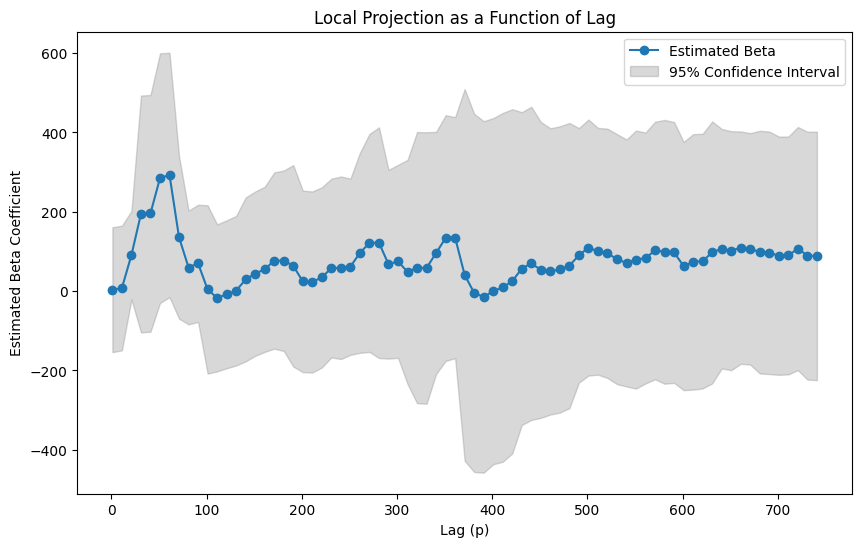

In [36]:
estimator = e.Estimator(W=fed, Y=data,treatment="Numeric Change", outcome="MTSLRRT$ Index")
#estimator.local_projection(p=200,min_obs=2, other_controls=None,lagW = [30], lagY=[0])         for usage example
estimator.plot_local_projection(p_range=[k for k in range(1,750,10)],min_obs=40,other_controls=["CPI XYOY Index"],lagW = [30], lagY=[0])

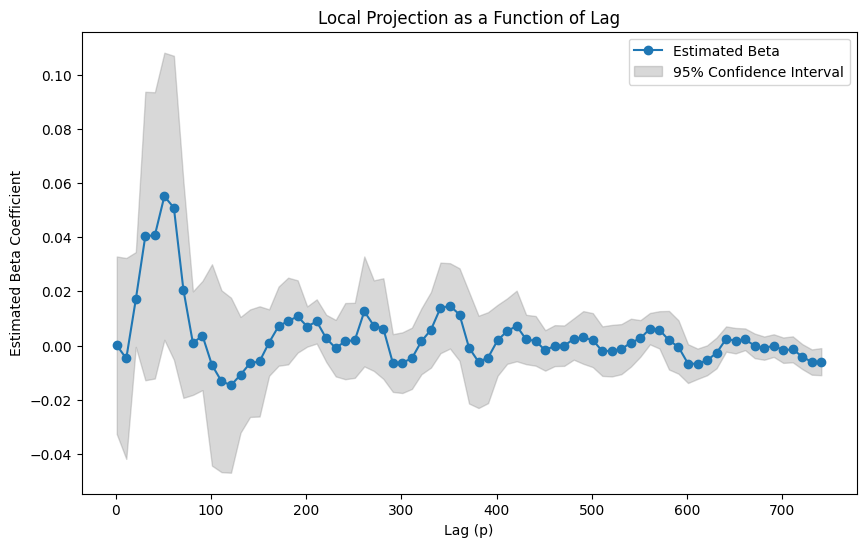

In [34]:
estimator = e.Estimator(W=fed, Y=data,treatment="Numeric Change", outcome="IP  CHNG Index")
#estimator.local_projection(p=200,min_obs=2, other_controls=None,lagW = [30], lagY=[0])         for usage example
estimator.plot_local_projection(p_range=[k for k in range(1,750,10)],min_obs=40,other_controls=["CPI XYOY Index"],lagW = [30], lagY=[0])

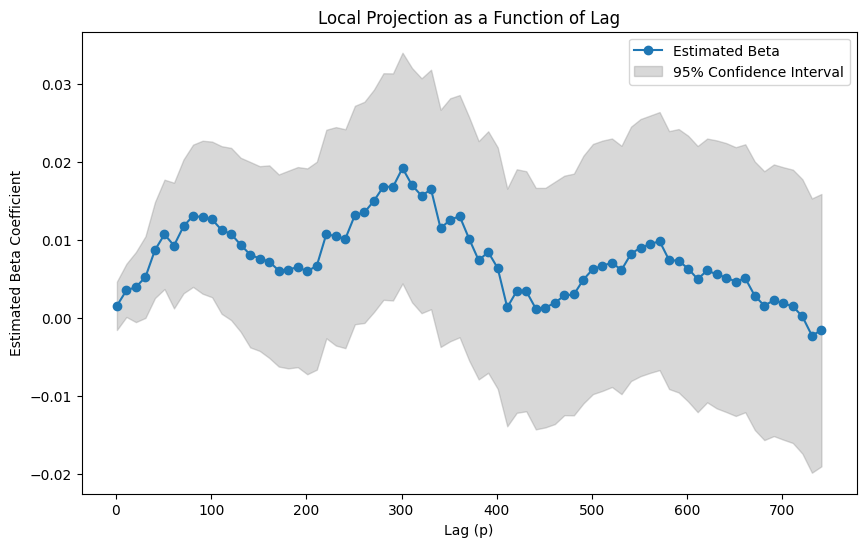

In [9]:
estimator = e.Estimator(W=fed, Y=data,treatment="Numeric Change", outcome="CPICYOY Index")
#estimator.local_projection(p=200,min_obs=2, other_controls=None,lagW = [30], lagY=[0])         for usage example
estimator.plot_local_projection(p_range=[k for k in range(1,750,10)],min_obs=40,lagW = [30], lagY=[0])

## Regression of the treatment

In [10]:
features={
    "USURTOT Index": [0], 
    "FEDFUNDS": [0],
    "CPICYOY Index" : [0]
}

reg, preds = estimator.regress_treatment(p=100, features = features)
preds["residuals"] = preds["Actual_W"] - preds["Predicted_W"]


W_res = preds[["residuals"]].copy()

preds.index = pd.to_datetime(preds.index).to_period('M').to_timestamp()
preds.index.name="Date"

compare = RR.join(preds[["residuals"]], how="left") #to compare with Romer-Romer
compare["residuals"] = compare["residuals"]/70

preds

,Actual_W,Predicted_W,residuals
Date,,,
1997-03-01,0,-6.366307,6.366307
1997-05-01,0,-6.198723,6.198723
1997-07-01,0,-6.953772,6.953772
1997-08-01,0,-6.983895,6.983895
1997-09-01,0,-7.079921,7.079921
...,...,...,...
2022-11-01,75,25.498037,49.501963
2023-02-01,25,20.021329,4.978671
2023-05-01,25,12.380167,12.619833


In [11]:
u.multi_axis_line_plot(compare, ["residuals", "resid_romer"], title="Romer-Romer vs. Our Residuals", y_axis_title="Residuals", x_axis_title="Time")

In [12]:
u.xy_scatter_plot(compare, x_col = "residuals", y_col = "resid_romer")

## Estimator using residualized treatment

In [16]:
W_res = (W_res-W_res.mean())/W_res.std()

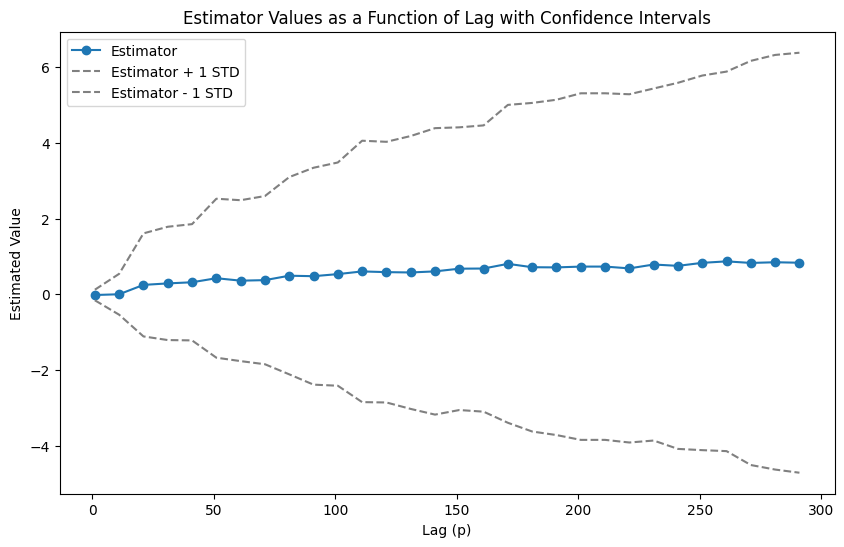

In [24]:
estimator= e.Estimator(W=W_res, Y=data,treatment="residuals", outcome="USURTOT Index")
#estimator.compute_estimator( p=10, h=5, w=25, w_prime=-25, min_obs=2)
estimator.plot_effect( h=0.1, w=1, w_prime=0, p_range=[k for k in range(1,300,10)], min_obs=20)

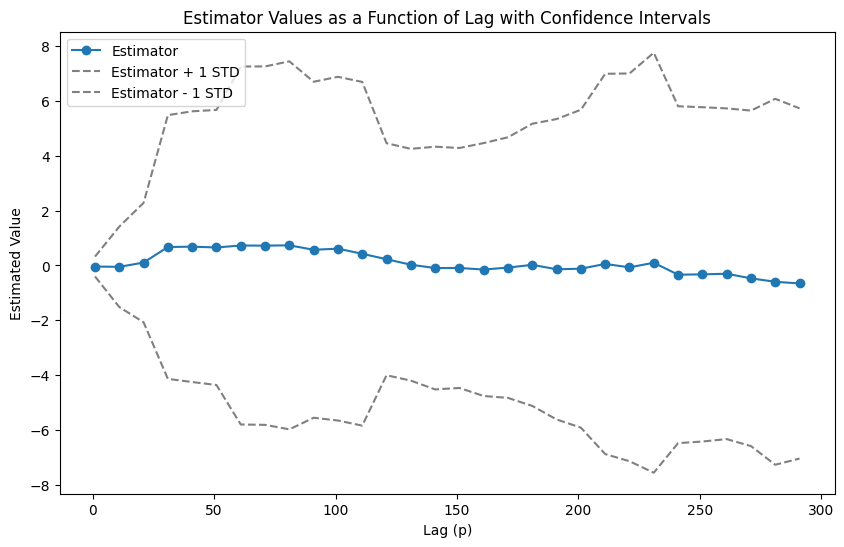

In [20]:
estimator= e.Estimator(W=W_res, Y=data,treatment="residuals", outcome="CPICYOY Index")
#estimator.compute_estimator( p=10, h=5, w=25, w_prime=-25, min_obs=2)
estimator.plot_effect( h=0.1, w=1, w_prime=0, p_range=[k for k in range(1,300,10)], min_obs=20)

# Estimator using Romer-Romer shocks

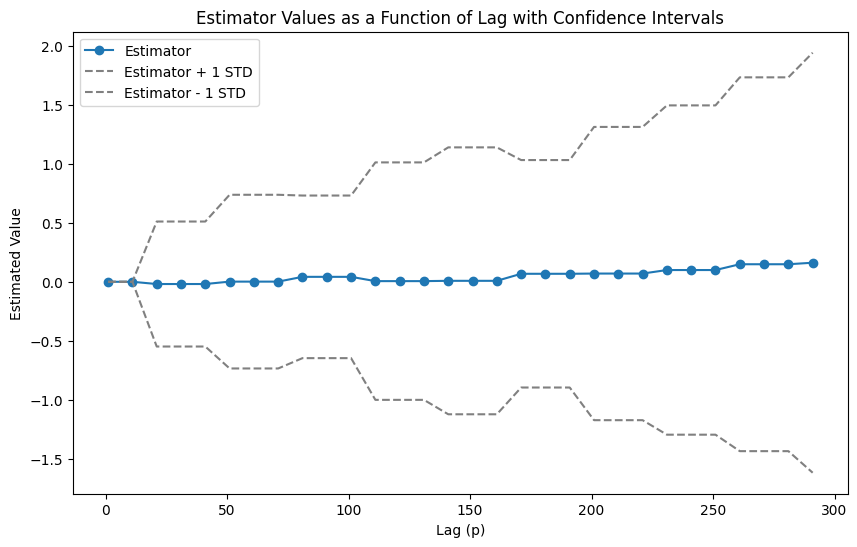

In [39]:
estimator= e.Estimator(W=RR[["resid_romer"]], Y=data,treatment="resid_romer", outcome="USURTOT Index")
#estimator.compute_estimator( p=10, h=5, w=25, w_prime=-25, min_obs=2)
estimator.plot_effect( h=0.15, w=0.5, w_prime=0, p_range=[k for k in range(1,300,10)], min_obs=30)

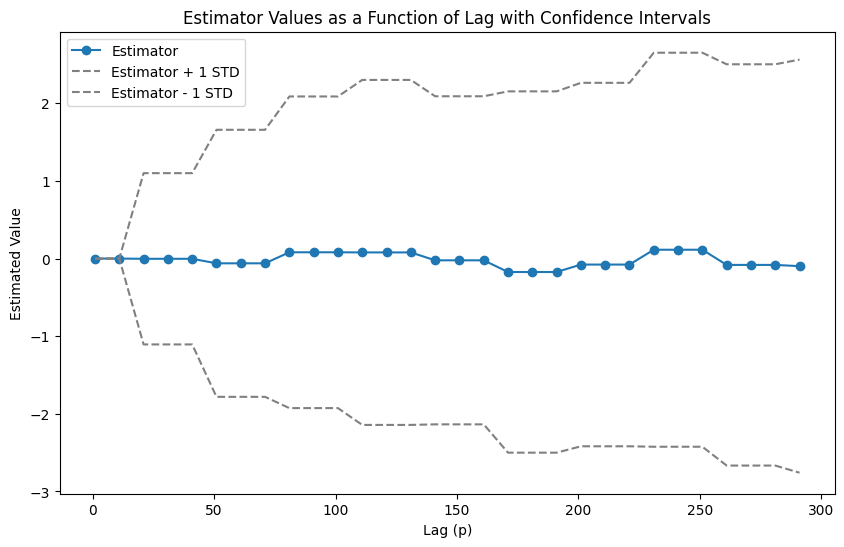

In [23]:
estimator= e.Estimator(W=RR[["resid_romer"]], Y=data,treatment="resid_romer", outcome="CPICYOY Index")
#estimator.compute_estimator( p=10, h=5, w=25, w_prime=-25, min_obs=2)
estimator.plot_effect( h=0.1, w=0.15, w_prime=0, p_range=[k for k in range(1,300,10)], min_obs=20)